### Test case LVV-T1074 - Sky Brightness precision

The maximum error in the precision of the sky brightness determination shall be less than **SBPerc = 1** percent.

#### Discussion

This test can be run using data products produced during regular reprocessing campaigns executed by the Data Management pipelines team. Specifically, we will use the regularly-reprocessed HSC RC2 data as reprocessed with weekly pipelines version w_2024_34, in Butler collection “HSC/runs/RC2/w_2024_34/DM-45857".

In [1]:
import numpy as np
from astropy.stats import sigma_clip as sc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, clear_output

from lsst.daf.butler import Butler
from lsst.pipe.tasks.background import MaskObjectsTask

We will measure this using the `calexp` images, and the `skyCorr` models, executing the following *for each detector, for each test visit*:
 - Grow the `calexp` masks via iteration of sky-subtraction and detection, as done by `skyCorr` prior to sky estimation
 - Subtract the `skyCorr` model from its associated `calexp`
 - Using the grown masks, mask the sky-subtracted `calexp` using the default mask planes utilized by `skyCorr`
 - Convert image flux to nanojanskies
 - Measure and record the per-pixel standard deviation of the unmasked sky background pixel fluxes

Additionally, we will measure this using the `sourceTable_visit` tables, executing the following *for each test visit*:
 - Trim the `sourceTable_visit` tables to include only sky objects
 - Divide the summed `ap09Flux` fluxes by the circular aperture area to derive the mean fluxes within each aperture
 - Measure and record the per-pixel standard deviation of these sky object mean fluxes, corrected for the $\sqrt{N}$ noise reduction induced by using the mean within an aperture
 - Record the ratios between the standard deviations of the image backgrounds and sky object fluxes to the visit's mean sky brightness, derived as the mean of the `calexp` metadata `BGMEAN` parameters for all CCDs

Image and metadata retrieval is wrapped into a function called `skySubImage`, and sky object retrieval is wrapped into a function called `retrieveSkyObjects`, in the following two cells:

In [2]:
def skySubImage(visit, detector):
    '''Produces a sky-subtracted calexp, where sky is the skyCorr full focal
    plane model.

    Parameters
    ----------
    visit : `int`
        Visit ID
    detector : `int`
        CCD ID

    Returns
    -------
    calexp : `ImageF`
        Calexp with FFP sky model subtracted from it, converted to nJy flux
    `metaData` : `dict`
        Dictionary of calexp metadata, including mean BG flux (in nJy)
    '''
    # Retrieve the skyCorr background list
    dataId = {"instrument": "HSC", "visit": visit, "detector": detector}
    skyCorrList = butler.get("skyCorr",
                             dataId=dataId,)
    skyCorr = skyCorrList.getImage()

    # Retrieve the image, metadata, and calibration
    calexp = butler.get("calexp",
                         dataId=dataId,)
    metaData = calexp.info.getMetadata().toDict()
    photoZp = calexp.getPhotoCalib().instFluxToNanojansky(1)

    # Iterate the masking following skyCorr
    mask = MaskObjectsTask(name="tmp")
    mask.findObjects(calexp)  # Iterates detection and sky-subtraction to grow masks

    # Subtract the FFP model and convert everything to nJy
    calexp.image -= skyCorr
    calexp.image.array *= photoZp
    metaData["BGMEAN"] *= photoZp
    metaData["BGVAR"] *= photoZp

    return calexp, metaData

In [3]:
def retrieveSkyObjects(visit, aper=9):
    '''Retrieve the sky objects aperture fluxes for a given visit.

    Parameters
    ----------
    visit : `int`
        Visit ID
    aper : `int`
        Choice of sky object aperture radius.  Valid are 3,6,9,12,25,35,70
        9 is recommended as sky objects are defined as being >8px from the
        nearest detection.

    Returns
    -------
    skyObjs : pandas `Series`
        Total fluxes of sky objects within circular aperture of radius aper,
        nJy
    '''
    # Retrieve table
    dataId = {"instrument": "HSC", "visit": visit}
    srcTab = butler.get("sourceTable_visit", dataId=dataId)
    isSky = (srcTab["sky_source"] > 0)  # Pick only sky objects
    skyObjs = srcTab[isSky]["ap%02dFlux" % (aper)]  # Units are nJy already

    return skyObjs

Estimation of the background and sky object standard deviations are wrapped into functions called `deriveBgNoise` and `deriveObjNoise`, in the following cells:

In [4]:
def deriveBgNoise(visit, detector):
    '''Derives the clipped standard deviation of the background of the
    sky-subtracted calexps for a single visit.

    Parameters
    ----------
    visit : `int`
        Visit ID
    detector : `int`
        CCD ID

    Returns
    -------
    sigSkyBg : `float`
        Clipped standard deviation of sky-subtracted background flux, nJy
    noiseFracBg : `float`
        Ratio between sigSkyBg and mean sky brightness of exposure
    '''
    # Retrieving images
    ssImage, metaData = skySubImage(visit, detector)

    # Masking the sky-subtracted image of sources/other things
    mask = ssImage.maskedImage.mask
    bad_mask_bit_mask = mask.getPlaneBitMask(badMaskPlanes)
    good = (mask.array.astype(int) & bad_mask_bit_mask) == 0

    # Sigma-clipping the background pixel fluxes
    clipSkyBackground = sc(ssImage.image.array[good], sigma=3, maxiters=3, masked=False)

    sigSkyBg = np.nanstd(clipSkyBackground)

    # Sky accuracy estimates
    noiseFracBg = sigSkyBg / metaData["BGMEAN"]

    return sigSkyBg, noiseFracBg

In [5]:
def deriveObjNoise(visit, bgMean, aper=9):
    '''Derives the clipped standard deviation of the sky objects for a
    single visit.
    
    Parameters
    ----------
    visit : `int`
        Visit ID
    bgMean : `float`
        Mean of BGMEAN parameters for all calexp metadata for visit
    aper : `int`
        Choice of sky object aperture radius.  See retrieveSkyObjects()

    Returns
    -------
    sigSkyObj : `float`
        Clipped standard deviation of mean sky object fluxes within aperture,
        nJy
    noiseFracObj : `float`
        Ratio between sigSkyObj and mean sky brightness of exposure
    '''
    # Retrieving catalog
    skyObjs1 = retrieveSkyObjects(visit, aper)

    # Sigma-clipping the mean fluxes within sky object apertures
    nPix = np.pi*aper**2  # Number of pixels per aperture
    clipSkyObjs = sc(skyObjs1/nPix, sigma=3, maxiters=3, masked=False)

    sigSkyObj = np.nanstd(clipSkyObjs) * np.sqrt(nPix)  # Converting to per-pixel

    # Sky accuracy estimate
    noiseFracObj = sigSkyObj / bgMean

    return sigSkyObj, noiseFracObj

In [6]:
# Initialize the butler repo pointing to the DM-45857 (w_2024_34) collection
repo = "/repo/main"
collection = "HSC/runs/RC2/w_2024_34/DM-45857"

butler = Butler(repo, collections=collection)

In [7]:
# Set the mask planes to ignore, following defaults in `background.py` used by `skyCorr`
badMaskPlanes = ["SAT", "BAD", "EDGE", "DETECTED", "DETECTED_NEGATIVE", "NO_DATA"]

For *M* visits, derive the background standard deviations and noise ratios of all CCDs and collate into lists.

In [8]:
# Setting up visits to examine
visits = [26044, 1270, 34382, 36190, 11700, 1244]  # GAMA G, I; VVDS G, I; COSMOS G, I
detectors = list(range(104))  # All science detectors
detectors.remove(9)  # Removing bad detector 9 from list

# Setting up a basic progress bar
pound = "#"
bounds = " "*(102) + "| %d" % (visits[0])

# Store results in a dictionary accessed by visit ID
noiseDict = {}
# Processing time here is long!
for vis in visits:
    noiseDict[vis] = {"sigSkyObj": None,
                      "sigSkyBg": [],
                      "noiseFracObj": None,
                      "noiseFracBg": []}
    # Reset progress bar per visit, label by visit ID
    if vis != visits[0]:
        pound = "#"
        bounds = " "*(102) + "| %d" % (vis)
    # Take the mean of the CCD backgrounds as the mean visit background
    bgMeans = []
    for det in detectors:
        sigSkyBg, noiseFracBg = deriveBgNoise(vis, det)
        noiseDict[vis]["sigSkyBg"].append(sigSkyBg)
        noiseDict[vis]["noiseFracBg"].append(noiseFracBg)
        bgMeans.append(sigSkyBg / noiseFracBg)

        # Progress bar code
        clear_output(wait=True)
        display(pound+bounds)
        pound += "#"
        bounds = bounds[1:]

    # Fill in the sky object values last, for each visit
    sigSkyObj, noiseFracObj = deriveObjNoise(vis, np.nanmean(bgMeans))
    noiseDict[vis]["sigSkyObj"] = sigSkyObj
    noiseDict[vis]["noiseFracObj"] = noiseFracObj

'#######################################################################################################| 1244'

Print the standard deviations derived each way to the screen, for each visit, and print the ratios between these and the mean background flux.

In [9]:
print("Standard deviations and ratios with mean background flux for each RC2 visit tested")
print("==================================================================================")
for key in noiseDict.keys():
    print("Visit %d: sigBG=%.3f nJy, sigObjs=%.3f nJy, sigBG/fBG=%.3f, sigObjs/fObjs=%.3f"
          % (key, np.nanmean(noiseDict[key]["sigSkyBg"]), noiseDict[key]["sigSkyObj"],
            np.nanmean(noiseDict[key]["noiseFracBg"]), noiseDict[key]["noiseFracObj"]))

Standard deviations and ratios with mean background flux for each RC2 visit tested
Visit 26044: sigBG=4.044 nJy, sigObjs=5.695 nJy, sigBG/fBG=0.024, sigObjs/fObjs=0.033
Visit 1270: sigBG=6.349 nJy, sigObjs=9.383 nJy, sigBG/fBG=0.017, sigObjs/fObjs=0.018
Visit 34382: sigBG=4.385 nJy, sigObjs=8.418 nJy, sigBG/fBG=0.023, sigObjs/fObjs=0.042
Visit 36190: sigBG=7.056 nJy, sigObjs=11.804 nJy, sigBG/fBG=0.011, sigObjs/fObjs=0.019
Visit 11700: sigBG=3.229 nJy, sigObjs=5.157 nJy, sigBG/fBG=0.014, sigObjs/fObjs=0.023
Visit 1244: sigBG=7.084 nJy, sigObjs=10.735 nJy, sigBG/fBG=0.009, sigObjs/fObjs=0.013


The standard deviation measured from the background measures the pixel-to-pixel uncertainty across the entire image, while that measured from the sky objects measures the same uncertainty on larger (9px radius aperture) scales.  Larger standard deviations measured within apertures suggests...?  (advice here appreciated)

The ratio between the standard deviation and the mean background flux subtracted from the images is a metric to measure the `SBPerc` metric specified in the requirement.  Across all visits tested (spanning two photometric bands in three tracts), this requirement is typically not met, regardless of the spatial scale over which the metric is calculated.

#### Plots

Create box and whisker plots showing distributions of standard deviations in sky-subtracted backgrounds for each visit (left panel), and distributions of ratios between those standard deviations and the mean sky brightness (right panel).  To meet the requirements, the latter must be < 0.01 (red dotted line in right panel).  Red x's show same metrics  evaluated from sky objects.

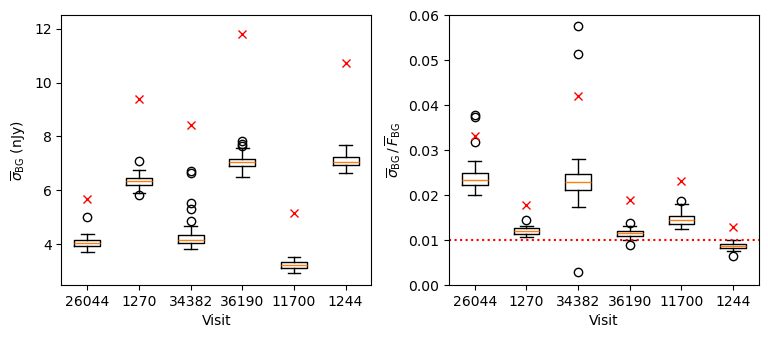

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3.5))
# Standard deviations
ax[0].boxplot([noiseDict[visits[i]]["sigSkyBg"] for i in range(len(visits))],
          tick_labels=visits)
ax[0].plot(np.arange(1, len(visits)+1), [noiseDict[key]["sigSkyObj"] for key in visits], "rx")
ax[0].set_ylim([2.5, 12.5])
ax[0].set_ylabel(r"$\overline{\sigma}_{\rm BG}$ (nJy)")
ax[0].set_xlabel("Visit")

# Standard deviations / mean background flux
ax[1].boxplot([noiseDict[visits[i]]["noiseFracBg"] for i in range(len(visits))],
          tick_labels=visits)
ax[1].plot(np.arange(1, len(visits)+1), [noiseDict[key]["noiseFracObj"] for key in visits], "rx")
ax[1].axhline(0.01, c="r", linestyle=":")
ax[1].set_ylim([0, 0.06])
ax[1].set_ylabel(r"$\overline{\sigma}_{\rm BG}\, /\, \overline{F}_{\rm BG}$")
ax[1].set_xlabel("Visit")
plt.subplots_adjust(wspace=0.25)

Retrieve masked `calexp` images of outliers in the `SBPerc` metric, to visualize where uncertainties in background estimation might arise.

In [14]:
# Find outlier indices for two visits
outIdx26044 = np.where(np.array(noiseDict[26044]["noiseFracBg"]) >= 0.03)[0]
outIdx34382 = np.where(np.array(noiseDict[34382]["noiseFracBg"]) >= 0.03)[0]

In [15]:
# Retrieve sky-subtracted images with iterated masks, mask images, store in lists
calexps = []
for i in outIdx26044:
    calexp, _ = skySubImage(26044, i)
    mask = calexp.maskedImage.mask
    bad_mask_bit_mask = mask.getPlaneBitMask(badMaskPlanes)
    good = (mask.array.astype(int) & bad_mask_bit_mask) == 0
    calexp.image.array[~good] = 0
    calexps.append(calexp)
for i in outIdx34382:
    dataId = {"instrument": "HSC", "visit": 34382, "detector": i}
    calexp = butler.get("calexp", dataId=dataId)
    mask = calexp.maskedImage.mask
    bad_mask_bit_mask = mask.getPlaneBitMask(badMaskPlanes)
    good = (mask.array.astype(int) & bad_mask_bit_mask) == 0
    calexp.image.array[~good] = 0
    calexps.append(calexp)

Show outlier `calexp` images, masked using same grown mask planes used to estimate the metric.

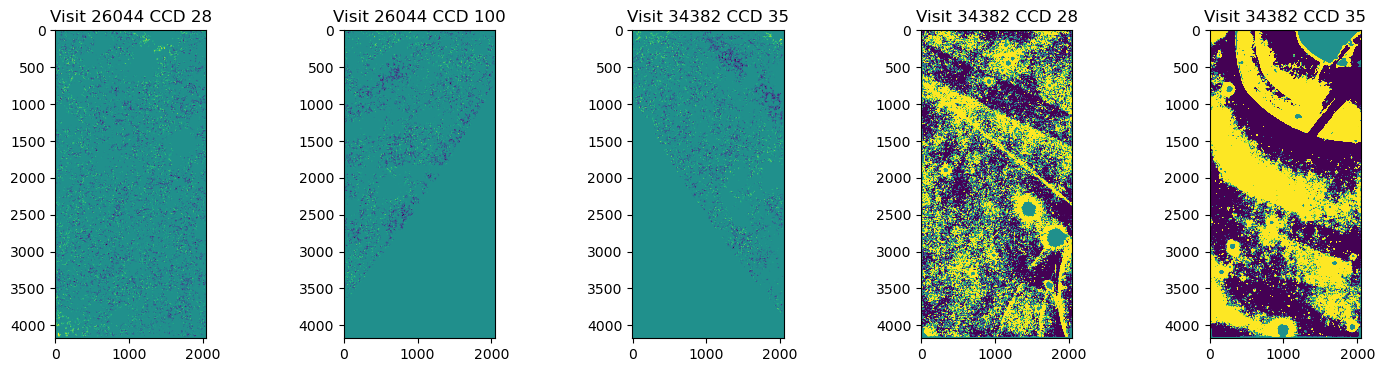

In [19]:
fig, ax = plt.subplots(1, len(calexps), figsize=(18, 4))
for i in range(len(calexps)):
    ax[i].imshow(calexps[i].image.array, vmin=-1, vmax=1)
    if i < 2:
        ax[i].set_title("Visit 26044 CCD %d" % (outIdx26044[i]))
    else:
        ax[i].set_title("Visit 34382 CCD %d" % (outIdx34382[i-len(outIdx26044)]))

#### Results

We have demonstrated that the sky estimation precision metric `SBPerc` can be tested using `calexp` images, their associated `skyCorr` models, and the sky objects values stored in the `sourceTable_visit` tables produced by the Rubin Science Pipelines.  The result of this test is "**Fail**", as in only one visit tested do we measure `SBPerc < 1`.